# compute AVO attributes from seismic

An add-on to the [AVO projection notebook](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/avo_projections.ipynb
) to show how to compute AVO attributes from seismic data.

## import libraries

The usual libraries are imported; note the use of [my version](https://github.com/aadm/geophysical_notes/blob/master/segypy.py) of `segypy` to load seismic data and [bruges](http://www.agilegeoscience.com/bruges/) from Agile Geoscience for reflectivity equations etc.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import segypy
import bruges as b
from scipy.interpolate import griddata
from scipy.interpolate import splev, splrep

%matplotlib inline
# comment out the following if you're not on a Mac with HiDPI display
%config InlineBackend.figure_format = 'retina'

colr='rainbow'

## load data

Also see the [seismic data](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/seismic_data_in_python.ipynb) and [amplitude extraction](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/seismic_amplitude_extraction.ipynb) notebooks for a somewhat more comprehensive overview of using seismic data in Python.

In [3]:
# load Top Heimdal time interpretation
hrz=np.recfromtxt('Top_Heimdal_subset.txt', names=['il','xl','z'])
# load avo intercept & gradient at Top Heimdal
ig=np.recfromtxt('RG_3dinv.txt', names=['i','g','z','xl','il'], skip_header=16)

# gridding
inl=np.arange(1300,1502,2)
crl=np.arange(1500,2002,2)
xi = np.linspace(inl.min(), inl.max(),250)
yi = np.linspace(crl.min(), crl.max(),250)
X, Y = np.meshgrid(xi, yi)
Z = griddata((hrz['il'], hrz['xl']), hrz['z'], (X,Y), method='cubic')
I=griddata((ig['il'],ig['xl']),ig['i'],(X,Y),method='cubic')
G=griddata((ig['il'],ig['xl']),ig['g'],(X,Y),method='cubic')

## calculate AVO attributes

The bulk of this was done in about half an hour after work, and it could be that I missed something very obvious!

I use Shuey's approach which basically computes a linear regression of near and far amplitudes against $\sin^2(\theta)$, where $\theta$ is the average angle of incidence related to each angle stack; I don't actually have this piece of information for the QSI angle stacks but I can guesstimate to be around 10 and 30 degrees.

First I load near and far angle stack then extract amplitudes from these two volumes along a certain horizon (it will be fairly easy to use the method also on timeslices, 2D sections and 3D volumes too).

The original dataset also has AVO Intercept and Gradient at Top Heimdal which are good so I can compare Intercept and Gradient calculated in Python to see if they make sense.

In [4]:
filename='3d_nearstack.sgy'
f=open(filename, 'rb')
seis,header,trace_headers=segypy.read_segy(f)
near=seis.reshape(header['ns'],inl.size,crl.size)

filename='3d_farstack.sgy'
f=open(filename, 'rb')
seis,header,trace_headers=segypy.read_segy(f)
far=seis.reshape(header['ns'],inl.size,crl.size)

lagtime=trace_headers['LagTimeA'][0]*-1
twt=np.arange(lagtime,header['dt']/1e3*header['ns']+lagtime,header['dt']/1e3)

The following lines are to extract amplitudes at Top Heimdal from the two cubes (see also [this other notebook](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/seismic_amplitude_extraction.ipynb) for techniques on amplitude extraction):

In [5]:
hrz_extr=np.zeros((hrz.size,5))
twt_finer=np.arange(hrz['z'].min(), hrz['z'].max(),0.1) # creates twt scale at 0.1 ms scale

for i in range(hrz.size):
    ii_idx=inl.tolist().index(hrz['il'][i])
    cc_idx=crl.tolist().index(hrz['xl'][i])
    zz_idx = np.abs(twt-hrz['z'][i]).argmin()

    trace_near = near[:, ii_idx, cc_idx].flatten()
    trace_far = far[:, ii_idx, cc_idx].flatten()
    amp_near = splev(hrz['z'][i], splrep(twt, trace_near))
    amp_far = splev(hrz['z'][i], splrep(twt, trace_far))

    hrz_extr[i,0] = hrz['il'][i]
    hrz_extr[i,1] = hrz['xl'][i]
    hrz_extr[i,2] = hrz['z'][i]
    hrz_extr[i,3] = amp_near
    hrz_extr[i,4] = amp_far

Then I grid Near (`An`) and Far (`Af`) amplitude maps:

In [6]:
An=griddata((hrz_extr[:,0],hrz_extr[:,1]),hrz_extr[:,3],(X,Y),method='cubic')
Af=griddata((hrz_extr[:,0],hrz_extr[:,1]),hrz_extr[:,4],(X,Y),method='cubic')

To calculate intercept and gradient I will use simple linear regression on near and far amplitudes (i.e., Shuey's equation approach). I have tried `numpy.polyfit` and `scipy.stats.linregress` which have to be run inside a for loop, then a function which I have discovered on [stackexchange](
http://stackoverflow.com/questions/22646602/python-multiple-simple-linear-regression) which relies on arrays computation and makes it so fast it's almost unbelievable.

I need to reshape near and far amplitudes as well as create angle of incidence arrays (this actually took me far more time to figure it out then all the rest):

In [7]:
# reshape arrays in this way
# x-axis:  sin^2(ang_near)  sin^2(ang_far)
#          sin^2(ang_near)  sin^2(ang_far)
#          ...
#          sin^2(ang_near)  sin^2(ang_far)

# y-axis:  AMP_near         AMP_far
#          AMP_near         AMP_far
#          ...
#          AMP_near         AMP_far

ang_n=10
ang_f=30
x = np.sin(np.deg2rad([ang_n,ang_f]))**2

dd=An.size # number of rows will be equal to total number of cells of amplitude maps

xx = np.reshape(np.resize(x,dd*2),(dd,2))
yy = np.empty(xx.shape)
yy[:,0] = An.flatten()
yy[:,1] = Af.flatten()

print '*** x-coordinates array; each row is the linearized angle for near and far'
print xx
print '*** y-coordinates array; each row is the near and far amplitudes for each cell of the map'
print yy

*** x-coordinates array; each row is the linearized angle for near and far
[[ 0.03015369  0.25      ]
 [ 0.03015369  0.25      ]
 [ 0.03015369  0.25      ]
 ..., 
 [ 0.03015369  0.25      ]
 [ 0.03015369  0.25      ]
 [ 0.03015369  0.25      ]]
*** y-coordinates array; each row is the near and far amplitudes for each cell of the map
[[ 2110.7226424   -728.19741632]
 [ 2184.52815962  -467.9129527 ]
 [ 2266.63875684  -237.78724535]
 ..., 
 [ 1051.94537937  -195.94628335]
 [  677.66376198   -41.44698467]
 [  255.74028318   118.72370853]]


In [8]:
import time
from scipy import stats

def multiple_linregress(x, y):
    x_mean = np.mean(x, axis=1, keepdims=True)
    x_norm = x - x_mean
    y_mean = np.mean(y, axis=1, keepdims=True)
    y_norm = y - y_mean
    slope = (np.einsum('ij,ij->i', x_norm, y_norm) /
             np.einsum('ij,ij->i', x_norm, x_norm))
    intercept = y_mean[:, 0] - slope * x_mean[:, 0]
    return np.column_stack((slope, intercept))

avo_I1 = np.empty(An.size)
avo_G1 = np.empty(An.size)
print '****** np.polyfit ******'
start = time.time()
for j in range(An.size):
    y = np.array([An.flatten()[j], Af.flatten()[j]])
    gradient, intercept = np.polyfit(x,y,1)
    avo_I1[j]= intercept
    avo_G1[j]= gradient
end = time.time()
elapsed = end - start
print 'Time elapsed: {:.2f} seconds.'.format(elapsed)

avo_I2 = np.empty(An.size)
avo_G2 = np.empty(An.size)
print '****** stats.linregress ******'
start = time.time()
for j in range(An.size):
    y = np.array([An.flatten()[j], Af.flatten()[j]])
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    avo_I2[j]= intercept
    avo_G2[j]= slope   
end = time.time()
elapsed = end - start
print 'Time elapsed: {:.2f} seconds.'.format(elapsed)

avo_I3 = np.empty(An.size)
avo_G3 = np.empty(An.size)
print '****** multiple_linregress ******'
start = time.time()
out = multiple_linregress(xx,yy)
avo_G3=out[:,0]
avo_I3=out[:,1]
end = time.time()
elapsed = end - start
print 'Time elapsed: {:.2f} seconds.'.format(elapsed)

****** np.polyfit ******
Time elapsed: 13.19 seconds.
****** stats.linregress ******
Time elapsed: 14.18 seconds.
****** multiple_linregress ******
Time elapsed: 0.01 seconds.


Holy cow: on my work PC `numpy.polyfit` does the job in 26 seconds, `scipy.stats.linregress` in 60 and `multiple_linregress` in **0.01** seconds!!! (On my personal computer, a Macbook Pro 13" with Intel Core i5 2.6Ghz, the times are 13, 14 and 0.01 seconds; the third solution is so fast that it's tempting to try and calculate Intercept and Gradient on the entire volume).

In [9]:
print np.mean(avo_I1)
print np.mean(avo_I2)
print np.mean(avo_I3)

print np.mean(avo_G1)
print np.mean(avo_G2)
print np.mean(avo_G3)

1353.68785841
1353.68785841
1353.68785841
-3199.12983891
-3199.12983891
-3199.12983891


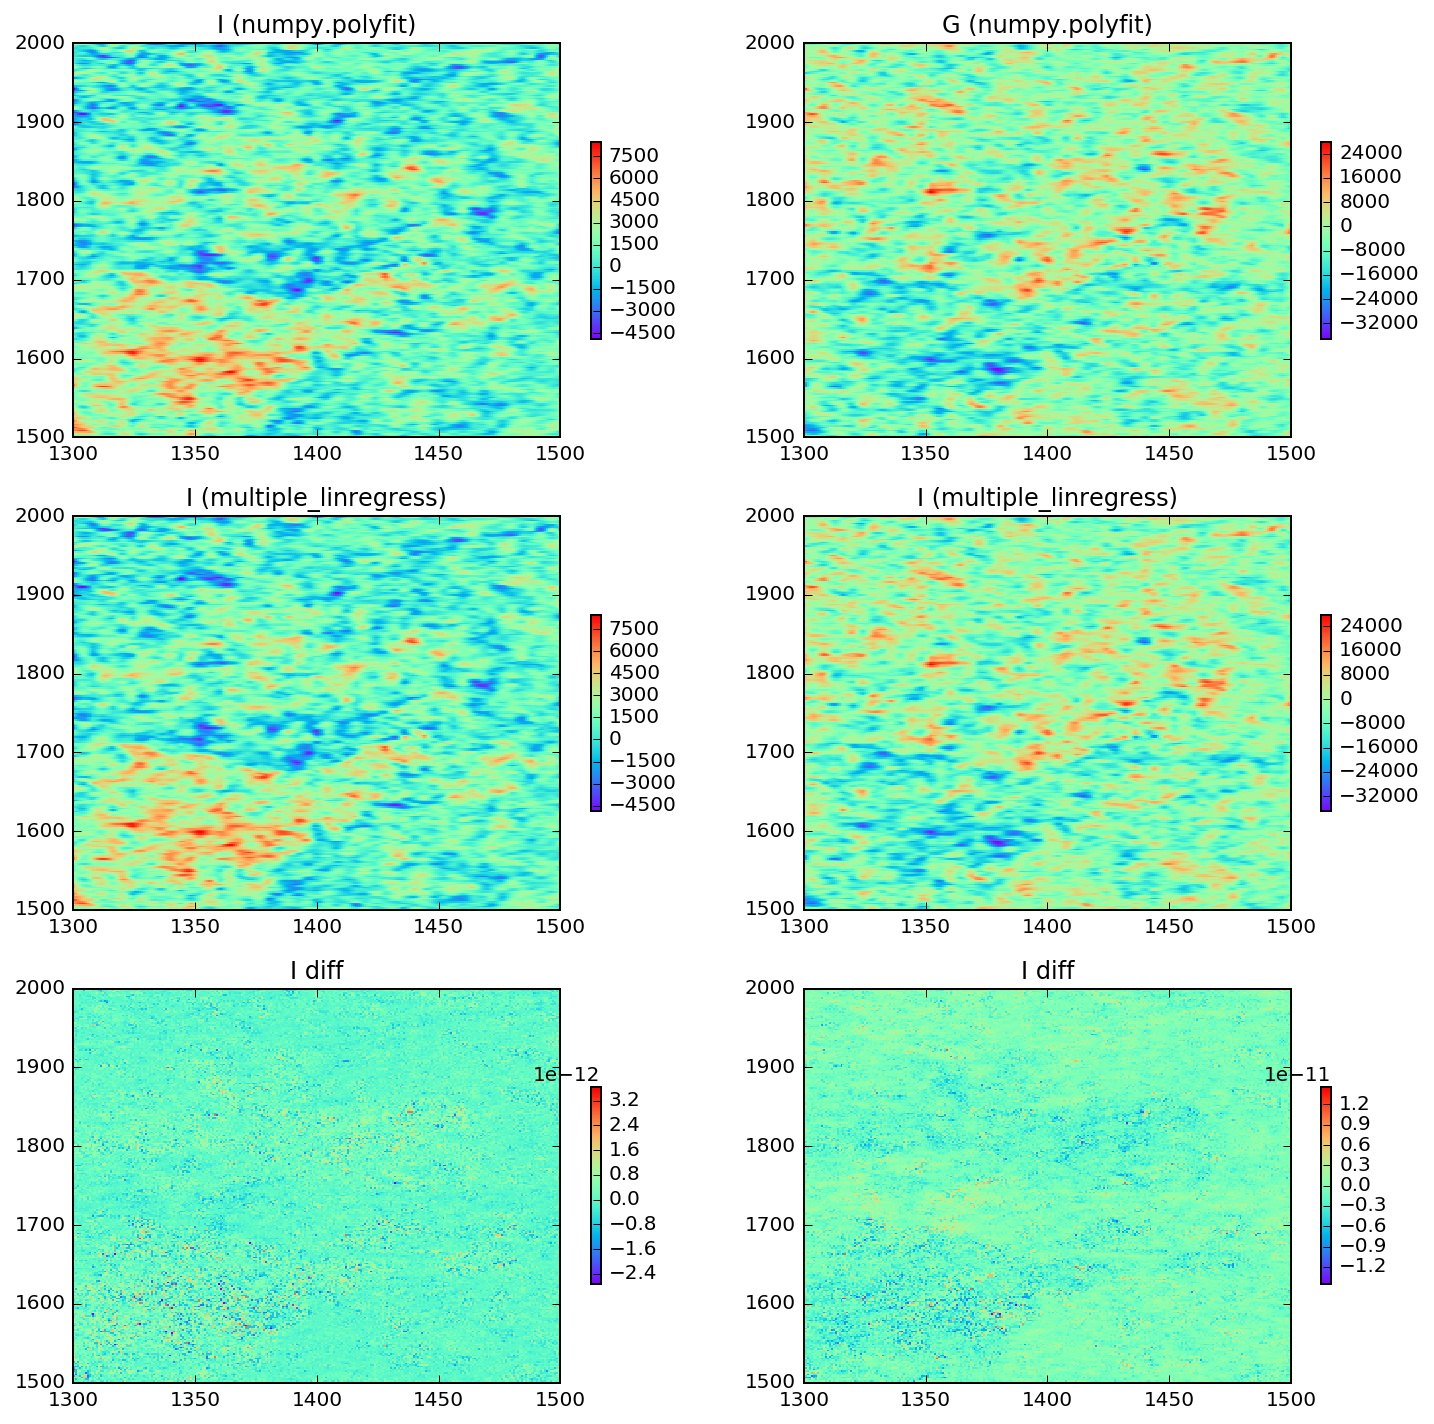

In [10]:
avo_I1=avo_I1.reshape(X.shape)
avo_G1=avo_G1.reshape(Y.shape)

avo_I3=avo_I3.reshape(X.shape)
avo_G3=avo_G3.reshape(Y.shape)
    
f, ax = plt.subplots(nrows=3,ncols=2,figsize=(12,12))
map0 = ax[0,0].pcolormesh(X, Y, avo_I1, cmap=colr)
map1 = ax[0,1].pcolormesh(X, Y, avo_G1, cmap=colr)
map2 = ax[1,0].pcolormesh(X, Y, avo_I3, cmap=colr)
map3 = ax[1,1].pcolormesh(X, Y, avo_G3, cmap=colr)
map4 = ax[2,0].pcolormesh(X, Y, avo_I1-avo_I3, cmap=colr)
map5 = ax[2,1].pcolormesh(X, Y, avo_G1-avo_G3, cmap=colr)

ax[0,0].set_title('I (numpy.polyfit)')
ax[0,1].set_title('G (numpy.polyfit)')
ax[1,0].set_title('I (multiple_linregress)')
ax[1,1].set_title('I (multiple_linregress)')
ax[2,0].set_title('I diff')
ax[2,1].set_title('I diff')

plt.colorbar(map0, ax=ax[0,0], shrink=0.5)
plt.colorbar(map1, ax=ax[0,1], shrink=0.5)
plt.colorbar(map2, ax=ax[1,0], shrink=0.5)
plt.colorbar(map3, ax=ax[1,1], shrink=0.5)
plt.colorbar(map4, ax=ax[2,0], shrink=0.5)
plt.colorbar(map5, ax=ax[2,1], shrink=0.5)

Yesss! They are also the same!

## display

Displaying the original AVO maps with the new ones I have calculated I see similar ranges of values but different pictures; the main problem is that I don't really know anything about the provided intercept and gradient maps, so I will need to do compare the results obtained in Python with the output of a commercial application (e.g., Petrel, Hampson-Russell, etc).

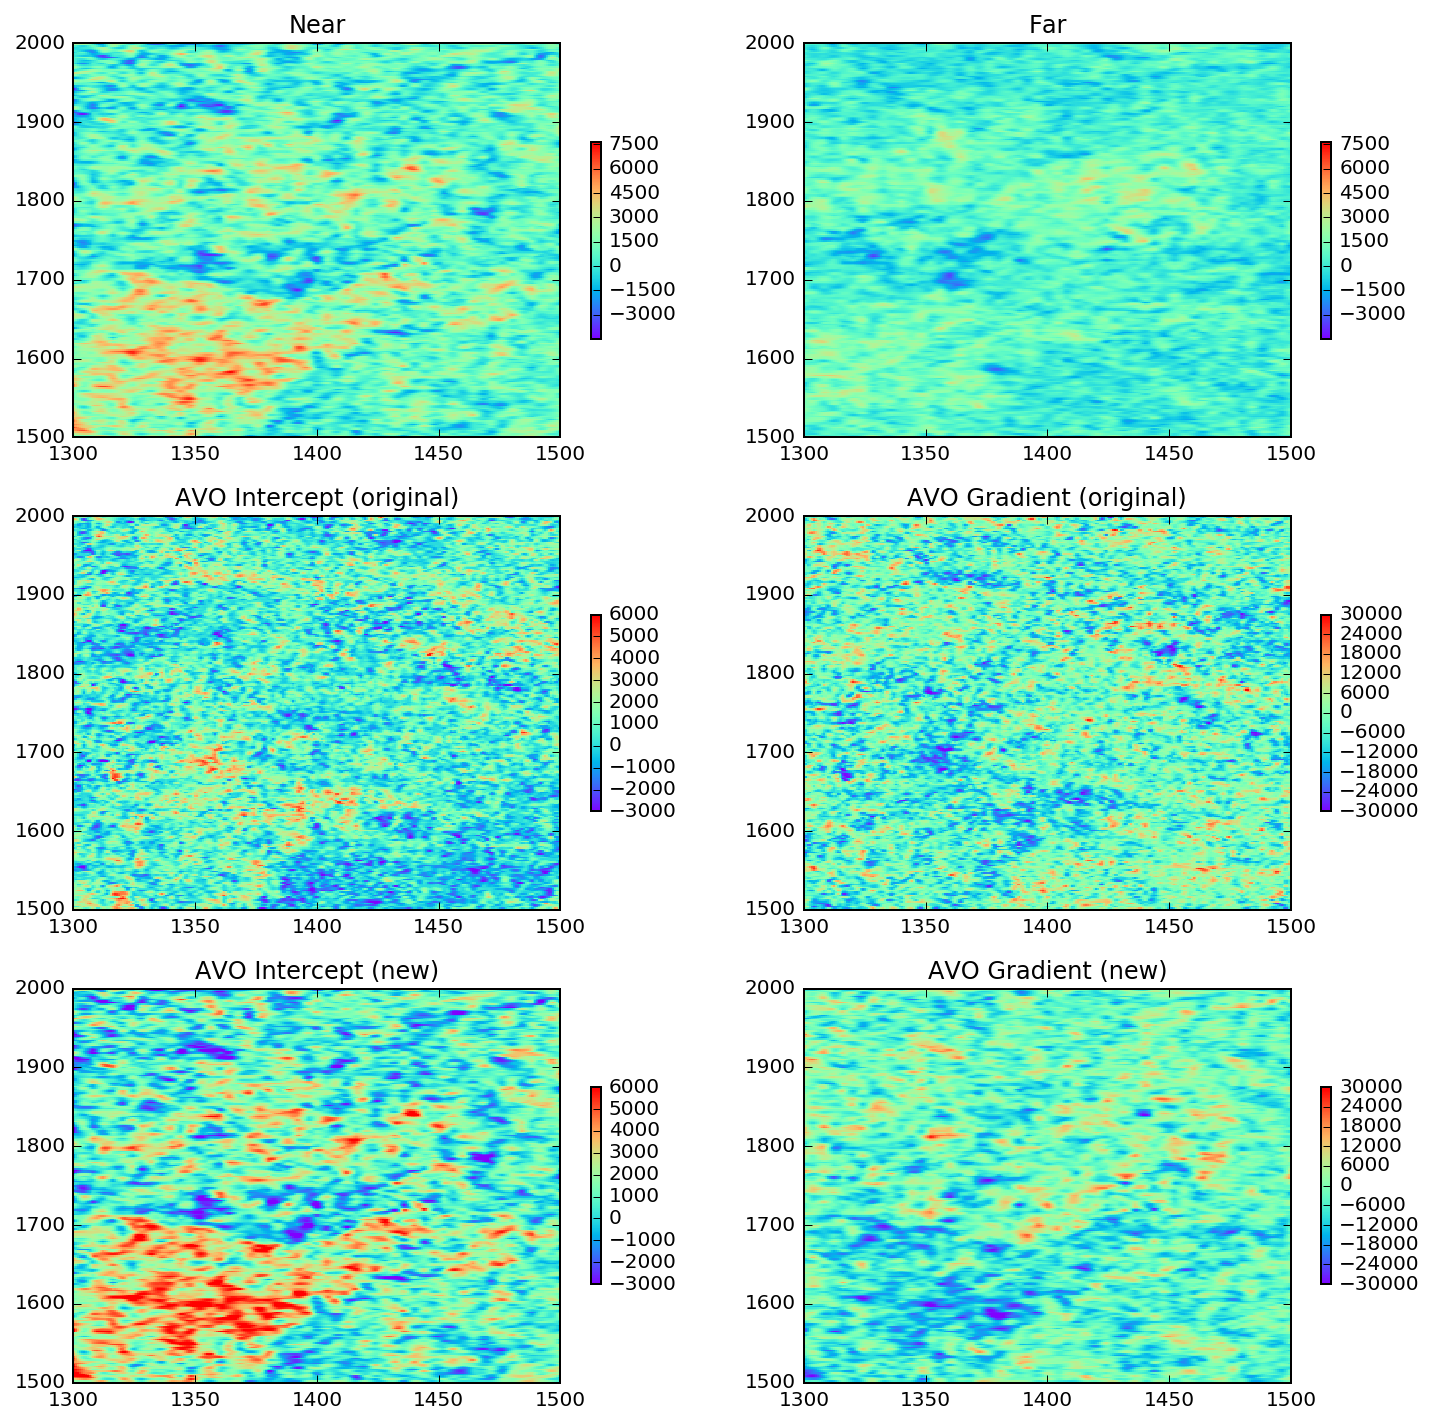

In [13]:
avo_I3=avo_I3.reshape(X.shape)
avo_G3=avo_G3.reshape(Y.shape)

clip_amp_max=np.max(hrz_extr[:,3:4])
clip_amp_min=np.min(hrz_extr[:,3:4])
    
f, ax = plt.subplots(nrows=3,ncols=2,figsize=(12,12))
map0 = ax[0,0].pcolormesh(X, Y, An, vmin=clip_amp_min, vmax=clip_amp_max, cmap=colr)
map1 = ax[0,1].pcolormesh(X, Y, Af, vmin=clip_amp_min, vmax=clip_amp_max, cmap=colr)
map2 = ax[1,0].pcolormesh(X, Y, I, vmin=-3000, vmax=6000, cmap=colr)
map3 = ax[1,1].pcolormesh(X, Y, G, vmin=-30000, vmax=30000, cmap=colr)
map4 = ax[2,0].pcolormesh(X, Y, avo_I3, vmin=-3000, vmax=6000, cmap=colr)
map5 = ax[2,1].pcolormesh(X, Y, avo_G3, vmin=-30000, vmax=30000, cmap=colr)

ax[0,0].set_title('Near')
ax[0,1].set_title('Far')
ax[1,0].set_title('AVO Intercept (original)')
ax[1,1].set_title('AVO Gradient (original)')
ax[2,0].set_title('AVO Intercept (new)')
ax[2,1].set_title('AVO Gradient (new)')

plt.colorbar(map0, ax=ax[0,0], shrink=0.5)
plt.colorbar(map1, ax=ax[0,1], shrink=0.5)
plt.colorbar(map2, ax=ax[1,0], shrink=0.5)
plt.colorbar(map3, ax=ax[1,1], shrink=0.5)
plt.colorbar(map4, ax=ax[2,0], shrink=0.5)
plt.colorbar(map5, ax=ax[2,1], shrink=0.5)